# 📚 Biliotecas & Funções

In [10]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
!pip install shap
import shap

In [92]:
# Separa as informações json em colunas distintas
def extract_json_columns(df, json_columns):
  """
  Separa as informações json em colunas distintas
  """
  for col in json_columns:
    df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    df = df.drop(columns=[col]).join(pd.json_normalize(df[col]))
  return df

# Função para calcular WoE
def calculate_woe(df, vr, cat):
    """
    Calcula o WoE de uma variável categórica em relação a uma variável resposta,
    cria uma nova coluna com a variável WoE e retorna esta coluna.
    """
    # Calcula total de bons e maus
    total_goods = df[df[vr] == 0].shape[0]
    total_bads = df[df[vr] == 1].shape[0]

    # Cria uma temporária para o cálculo do WoE
    temp = pd.crosstab(df[cat], df[vr])
    temp.columns = ['goods', 'bads']

    temp['prop_goods'] = temp['goods'] / total_goods
    temp['prop_bads'] = temp['bads'] / total_bads

    # Calcula o WoE para cada categoria. Adiciona um pequeno valor para evitar log(0)
    temp['WoE'] = np.log((temp['prop_bads'] + 1e-7) / (temp['prop_goods'] + 1e-7))

    # Retorna a nova coluna de WoE
    woe_dict = temp['WoE'].to_dict()

    return df[cat].map(woe_dict).copy()

def show_categories_woe(df, var_cat):
    var_woe = f'{var_cat}_woe'

    # Para previnir erros
    if var_cat not in df.columns or var_woe not in df.columns:
        print(f"A variável '{var_cat}' ou seu WoE não foram encontrados no DataFrame.")
        return

    # Cria um DataFrame temporário com a variável categórica e a variável WoE
    temp_df = df[[var_cat, var_woe]].drop_duplicates()
    temp_df.columns = ['Categorias', 'WoE']
    temp_df.sort_values(by=['WoE'], ignore_index=True, inplace=True)

    # Exibe a tabela
    print(f"Pesos das categorias '{var_cat}':")
    print(temp_df.to_string(index=False))

#📌 Extracão

In [4]:
# Extração primária
url_data = 'https://raw.githubusercontent.com/ingridcristh/challenge2-data-science/refs/heads/main/TelecomX_Data.json'
df = pd.read_json(url_data)
df.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


In [5]:
# Extrai colunas do json
json_cols = ['customer','phone','internet','account']
dfv2 = extract_json_columns(df.copy(), json_cols)

# Separa por "_"
dfv2.columns = dfv2.columns.str.replace(r'\.|(?<=[a-z])(?=[A-Z])', '_', regex=True).str.lower()

# Resultados
dfv2.head()

,customer_id,churn,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service,...,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,charges_monthly,charges_total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,...,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,...,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,...,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,...,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,...,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.4


#🔧 Transformação

In [6]:
# Análise da base
for col in dfv2.columns:
    print(f"Column: {col}")
    print(dfv2[col].unique())
    print("-" * 30)

print('')
dfv2.info()

Column: customer_id
['0002-ORFBO' '0003-MKNFE' '0004-TLHLJ' ... '9992-UJOEL' '9993-LHIEB'
 '9995-HOTOH']
------------------------------
Column: churn
['No' 'Yes' '']
------------------------------
Column: gender
['Female' 'Male']
------------------------------
Column: senior_citizen
[0 1]
------------------------------
Column: partner
['Yes' 'No']
------------------------------
Column: dependents
['Yes' 'No']
------------------------------
Column: tenure
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 28 41 53 68 51 31 36 17 18 38 42
  0]
------------------------------
Column: phone_service
['Yes' 'No']
------------------------------
Column: multiple_lines
['No' 'Yes' 'No phone service']
------------------------------
Column: internet_service
['DSL' 'Fiber optic' 'No']
------------------------------
Column: online_security
['No' 'Yes' 'No internet se

In [7]:
# Arruma categóricas
categoricas = list(dfv2.loc[:, 'gender':'payment_method'].columns)
categoricas.remove('tenure')

for i in categoricas:
  dfv2[i] = dfv2[i].astype('category')

dfv2['churn'] = dfv2['churn'].astype('category')

# Arruma numérica
dfv2['charges_total'] = dfv2['charges_total'].apply(lambda x: x if x.isnumeric() else np.nan).astype('float64')

# Resultado
dfv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   customer_id        7267 non-null   object  
 1   churn              7267 non-null   category
 2   gender             7267 non-null   category
 3   senior_citizen     7267 non-null   category
 4   partner            7267 non-null   category
 5   dependents         7267 non-null   category
 6   tenure             7267 non-null   int64   
 7   phone_service      7267 non-null   category
 8   multiple_lines     7267 non-null   category
 9   internet_service   7267 non-null   category
 10  online_security    7267 non-null   category
 11  online_backup      7267 non-null   category
 12  device_protection  7267 non-null   category
 13  tech_support       7267 non-null   category
 14  streaming_tv       7267 non-null   category
 15  streaming_movies   7267 non-null   category
 16  contra

In [8]:
# Cria variável resposta numérica
dfv2['churn_id'] = dfv2['churn'].apply(lambda x: 1 if x == 'Yes' else (0 if x == 'No' else np.nan)).astype('Int64')
dfv2['churn_id'].value_counts(dropna=False)

,count
churn_id,
0,5174
1,1869
<NA>,224


#📊 Carga e análise

In [9]:
# Remove linhas sem VR
dfv3 = dfv2.dropna(subset=['churn_id']).copy()
dfv3['churn_id'] = dfv3['churn_id'].astype('int64')
dfv3['charges_total'] = dfv3['charges_total'].fillna(0)

In [30]:
# Adiciona variáveis com WoE
for var in categoricas:
  dfv3[f'{var}_woe'] = calculate_woe(dfv3.copy(), 'churn_id', var)

# Variáveis com WoE
categoricas_woe = [var + "_woe" for var in categoricas]

In [12]:
for col in categoricas_woe:
    print(f"Column: {col}")
    print(dfv3[col].unique())
    print("-" * 30)

Column: gender_woe
[0.019602, -0.019409]
Categories (2, float64): [0.019602, -0.019409]
------------------------------
Column: senior_citizen_woe
[-0.156151, 0.682370]
Categories (2, float64): [-0.156151, 0.682370]
------------------------------
Column: partner_woe
[-0.389128, 0.308156]
Categories (2, float64): [0.308156, -0.389128]
------------------------------
Column: dependents_woe
[-0.681473, 0.231141]
Categories (2, float64): [0.231141, -0.681473]
------------------------------
Column: phone_service_woe
[0.008838, -0.084284]
Categories (2, float64): [-0.084284, 0.008838]
------------------------------
Column: multiple_lines_woe
[-0.078011, 0.103836, -0.084284]
Categories (3, float64): [-0.078011, -0.084284, 0.103836]
------------------------------
Column: internet_service_woe
[-0.434427, 0.691065, -1.507839]
Categories (3, float64): [-0.434427, 0.691065, -1.507839]
------------------------------
Column: online_security_woe
[0.685885, -0.747184, -1.507839]
Categories (3, float64):

In [19]:
# Correlação
corr_tenure = dfv3['tenure'].corr(dfv3['churn_id'])
corr_charges = dfv3['charges_monthly'].corr(dfv3['churn_id'])
corr_total = dfv3['charges_total'].corr(dfv3['churn_id'])

print(f"Correlação tenure: {corr_tenure:.4f}")
print(f"Correlação charges_monthly: {corr_charges:.4f}")
print(f"Correlação charges_total: {corr_total:.4f}")
# Há uma inversão no charges...

Correlação tenure: -0.3522
Correlação charges_monthly: 0.1934
Correlação charges_total: -0.0370


In [21]:
# Normaliza variáveis contínuas
scaler = MinMaxScaler()

dfv3['tenure_nor'] = scaler.fit_transform(dfv3[['tenure']])
dfv3['charges_monthly_nor'] = scaler.fit_transform(dfv3[['charges_monthly']])
dfv3['charges_total_nor'] = scaler.fit_transform(dfv3[['charges_total']])

In [31]:
# Adiciona variáveis contínuas normalizadas
categoricas_woe.append('tenure_nor')
categoricas_woe.append('charges_monthly_nor')
categoricas_woe.append('charges_total_nor')

## Separa treino e teste

In [32]:
# Separa amostras de treino e teste
df_train, df_test = train_test_split(dfv3, test_size=0.33, random_state=42, stratify=dfv3['churn_id'])

y_train = df_train['churn_id']
y_test = df_test['churn_id']

In [33]:
# Remove inversões
categoricas_woe.remove('gender_woe')
categoricas_woe.remove('streaming_movies_woe')
categoricas_woe.remove('streaming_tv_woe')
categoricas_woe.remove('phone_service_woe')
categoricas_woe.remove('multiple_lines_woe')
categoricas_woe.remove('device_protection_woe')
categoricas_woe.remove('online_backup_woe')
categoricas_woe.remove('partner_woe')
categoricas_woe.remove('charges_monthly_nor')
categoricas_woe.remove('charges_total_nor')

In [34]:
X_train = df_train[categoricas_woe]
X_test = df_test[categoricas_woe]

## Modelo

In [35]:
# Cria e treina modelo
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Betas do modelo
print(f'Intercepto: {model.intercept_:.4f}')
print('\nBetas:')
for i, col in enumerate(X_train.columns):
    print(f'{col}: {model.coef_[i]:.4f}')

Intercepto: 0.4705

Betas:
senior_citizen_woe: 0.0688
dependents_woe: 0.0322
internet_service_woe: 0.0809
online_security_woe: 0.0169
tech_support_woe: 0.0251
contract_woe: 0.0247
paperless_billing_woe: 0.0642
payment_method_woe: 0.0737
tenure_nor: -0.3518


## Desempenho

Erro Quadrático Médio: 0.1452
R-quadrado: 0.2550
KS: 0.5019
Gini: 0.6529



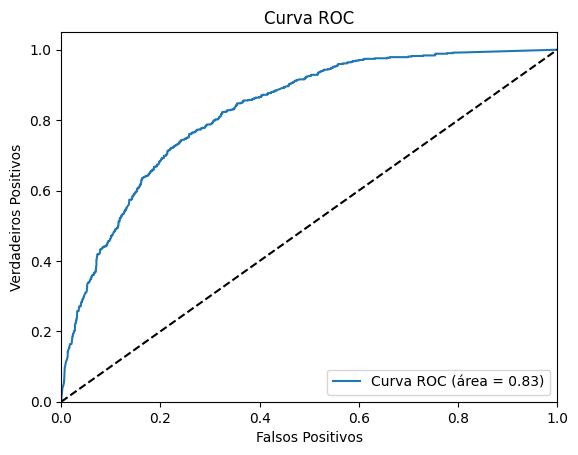

In [36]:
# Métricas de desempenho
y_pred_proba = np.clip(y_pred, 0, 1)

# Calcula MSE e R2
mse = mean_squared_error(y_test, y_pred_proba)
r2 = r2_score(y_test, y_pred_proba)

print(f'Erro Quadrático Médio: {mse:.4f}')
print(f'R-quadrado: {r2:.4f}')

# Calcula KS
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
ks_statistic = np.max(tpr - fpr)
print(f'KS: {ks_statistic:.4f}')

# Calcula Gini
auc = roc_auc_score(y_test, y_pred_proba)
gini = 2 * auc - 1
print(f'Gini: {gini:.4f}\n')

# Plota curva ROC
plt.figure()
plt.plot(fpr, tpr, label='Curva ROC (área = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos')
plt.ylabel('Verdadeiros Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

O modelo é bom!

## Importância das variáveis

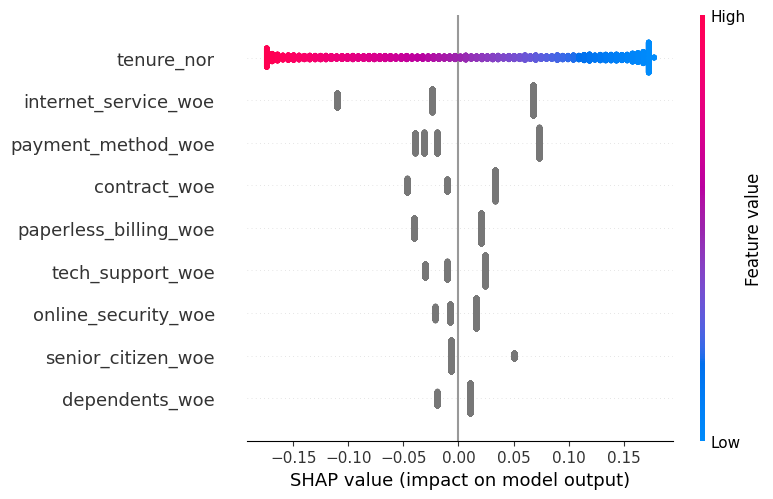

In [37]:
# calcula os shap values para o conjunto de treino
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_train)

# Sumariza a importância das variáveis
shap.summary_plot(shap_values, X_train)

#📄Relatorio Final

Para avaliar a capacidade das informações disponíveis de explicarem ou preverem o churn, eu fiz um modelo simples por regressão linear e e medi a força das variáveis pelos valores Shap.

Através disso, obtemos um modelo de capacidade preditiva boa (KS maior que 50), o que dá confiança aos resultados.

A variável mais explicativa do Churn é a Tenure, contínua, que possui uma correlação de -35%. Depois dela, as mais importantes são:
* Serviço de internet
* método de pagamento
* contrato
* pagamento sem papel
* suporte técnico
* segurança online
* senioridade
* dependendes

Para saber o comportamento das categorias em relação ao churn, use a função abaixo, sabendo que o WoE ("Weight of Evidence") é maior quanto maior o churn associado a ela.

In [93]:
# Para exibir o WoE de uma variável
var_show = 'online_security'
show_categories_woe(dfv3, var_show)

Pesos das categorias 'online_security':
         Categorias       WoE
                 No  0.685885
No internet service -1.507839
                Yes -0.747184
